In [ ]:
!unzip -q '/content/data/data.zip' -d '/content/data/'

**1. Load dataset**

In [ ]:
import pandas as pd

# Load only a subset of the data
train_data = pd.read_csv('/content/data/balanced_emnist_subset.csv')
test_data = pd.read_csv('/content/data/balanced_emnist_test_subset.csv')

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (987, 785)
Test data shape: (987, 785)


**2. Split data pixel dan label gambar**

In [ ]:
# Split features and labels
X_train = train_data.iloc[:, 1:].values  # Data pixel
y_train = train_data.iloc[:, 0].values   # Label

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (987, 784)
Shape of y_train: (987,)


**3. Ubah bentuk data dari array 1D ek array 2D**

In [ ]:
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
print("Reshaped X_train:", X_train.shape)

Reshaped X_train: (987, 28, 28)


**4. Extraxt fiture use HOG**

In [ ]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

def extract_hog_features(images):
    hog_features = []
    for image in images:
        hog_feat = hog(image,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys')
        hog_features.append(hog_feat)
    return hog_features

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Standarisasi fitur HOG
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

print("Shape of HOG features (X_train):", len(X_train_hog[0]))


Shape of HOG features (X_train): 144


**5. Training menggunakan SVM dan Evaluasi menggunakan LOOCV**

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Inisialisasi Leave-One-Out Cross-Validation dan model SVM
loo = LeaveOneOut()
model = SVC(kernel='linear', C=10.0)

# Variabel untuk menyimpan hasil
y_true = []
y_pred = []

# Loop LOOCV
for train_index, test_index in loo.split(X_train_hog):
    X_train_loo, X_test_loo = X_train_hog[train_index], X_train_hog[test_index]
    y_train_loo, y_test_loo = y_train[train_index], y_train[test_index]

    # Melatih model SVM
    model.fit(X_train_loo, y_train_loo)

    # Prediksi untuk sampel uji
    y_pred_loo = model.predict(X_test_loo)

    # simpan hasil
    y_true.append(y_test_loo[0])
    y_pred.append(y_pred_loo[0])

# eval performa
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Menampilkan hasil eval performa
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("F1 Score:", f1)


Accuracy: 0.6038500506585613
Confusion Matrix:
 [[12  1  0 ...  0  0  0]
 [ 0 10  0 ...  0  1  0]
 [ 0  0 16 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0 13  1]
 [ 0  0  0 ...  0  0 11]]
Precision: 0.6144604577975095
F1 Score: 0.605115087425164


**6. Plotting confusion matrix**

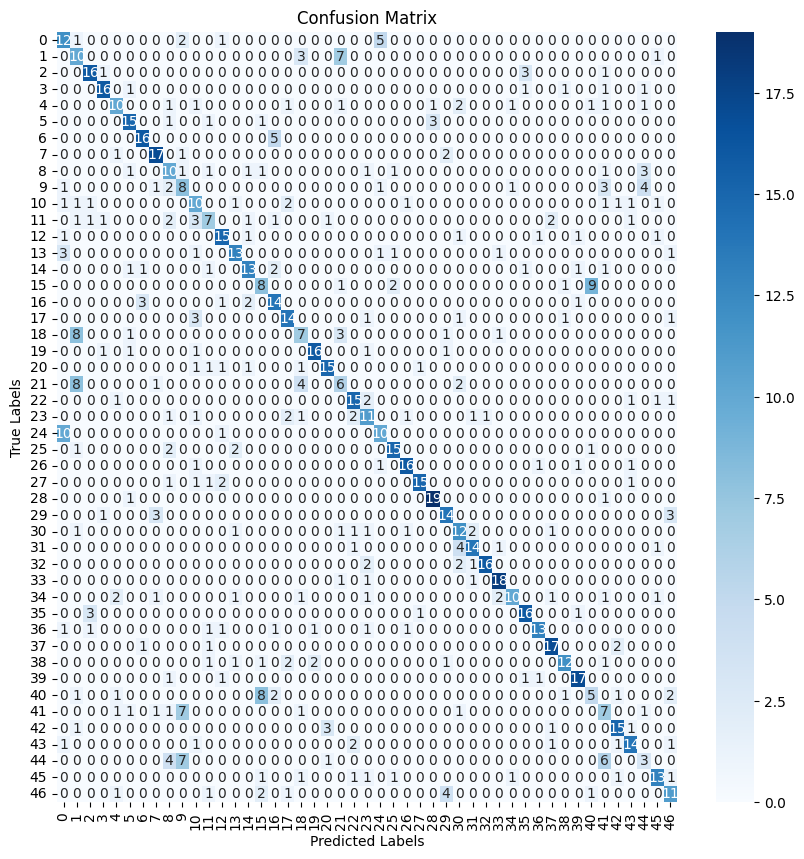

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


**7. Cek distribusi label pada dataset**

In [ ]:
# Periksa distribusi label di dataset
label_counts = train_data['24'].value_counts().sort_index()
print(label_counts)

24
0     21
1     21
2     21
3     21
4     21
5     21
6     21
7     21
8     21
9     21
10    21
11    21
12    21
13    21
14    21
15    21
16    21
17    21
18    21
19    21
20    21
21    21
22    21
23    21
24    21
25    21
26    21
27    21
28    21
29    21
30    21
31    21
32    21
33    21
34    21
35    21
36    21
37    21
38    21
39    21
40    21
41    21
42    21
43    21
44    21
45    21
46    21
Name: count, dtype: int64


**8. Preview hasil training**

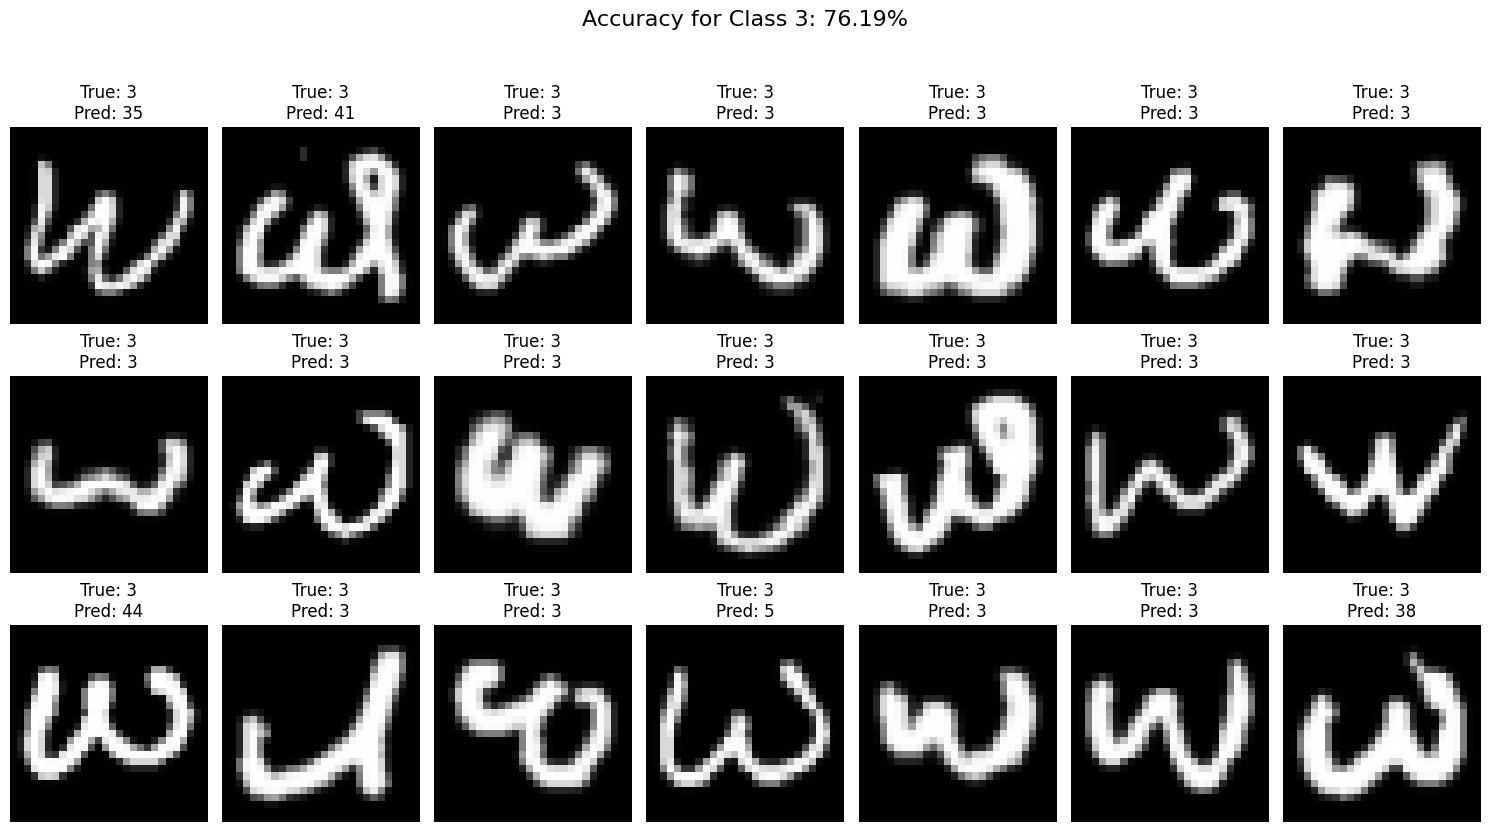

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Tentukan kelas yang ingin ditampilkan
target_class = 3

# Ambil indeks dari sampel di `y_test` yang sesuai dengan kelas target
indices_for_target_class = [i for i, label in enumerate(y_test) if label == target_class]

# Tentukan jumlah gambar yang ingin ditampilkan (21 gambar)
num_samples_to_show = 21
# Ambil sampel acak dari indeks yang sesuai
selected_indices = random.sample(indices_for_target_class, min(num_samples_to_show, len(indices_for_target_class)))

# Hitung akurasi untuk kelas yang ditargetkan
def calculate_accuracy(y_true, y_pred, target_class):
    correct_predictions = sum((y_pred[i] == y_true[i]) for i in range(len(y_true)) if y_true[i] == target_class)
    total_predictions = sum(1 for label in y_true if label == target_class)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

# Hitung akurasi untuk target_class
accuracy = calculate_accuracy(y_test, y_pred, target_class)

# Buat plot untuk menunjukkan gambar, prediksi, dan label aslinya
num_cols = 7  # Jumlah kolom
num_rows = (num_samples_to_show + num_cols - 1) // num_cols  # Hitung jumlah baris

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten axes array untuk memudahkan indexing
axes = axes.flatten()

for i, index in enumerate(selected_indices):
    ax = axes[i]
    image = X_test[index].reshape(28, 28)
    true_label = y_test[index]
    predicted_label = y_pred[index]

    # Tampilkan gambar
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'True: {true_label}\nPred: {predicted_label}')

# Menyembunyikan sisa subplot yang tidak digunakan
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Tampilkan akurasi di atas plot
plt.suptitle(f'Accuracy for Class {target_class}: {accuracy * 100:.2f}%', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Atur layout agar tidak bertabrakan dengan suptitle
plt.show()
